In [ ]:
pip install torch-fidelity wandb

In [ ]:
import os
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb
import time
from torch_fidelity import calculate_metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
config = {
    # dataset
    "dataset": "CIFAR-10",
    "image_size": 32,
    "channels": 3,

    # model
    "model": "KL-annealing-VAE",
    "latent_dim": 256,
    "encoder_channels": [32, 64, 128],

    # training
    "batch_size": 128,
    "epochs": 30,
    "lr": 2e-4,
    "recon_loss": "MSE",
    "beta": 0.25,
    "kl_anneal_epochs": 10,

    # evaluation
    "fid_every": 5,
    "fid_samples": 1000,
    "kid_subset_size": 300,

    # logging
    "log_images": True,
    "num_log_images": 16,
}

In [ ]:
run_name = (
    f"VAE_kl_annealing{config['beta']}_"
    f"z{config['latent_dim']}_"
    f"lr{config['lr']}"
)

wandb.init(
    project="generative-modeling-on-cifar-10",
    name=run_name,
    config=config
)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gioeba (gioeba-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
real_folder = "/tmp/cifar10_real"
gen_folder = "/tmp/cifar10_gen"
os.makedirs(real_folder, exist_ok=True)
os.makedirs(gen_folder, exist_ok=True)

In [ ]:
real_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=T.ToTensor()
)

if len(os.listdir(real_folder)) == 0:
    print("Saving real CIFAR-10 images...")
    for i in tqdm(range(10000)):
        img, _ = real_dataset[i]
        vutils.save_image(img, os.path.join(real_folder, f"real_{i}.png"))
else:
    print("Real images already exist, skipping.")

100%|██████████| 170M/170M [00:06<00:00, 25.9MB/s]


Saving real CIFAR-10 images...


100%|██████████| 10000/10000 [00:08<00:00, 1236.54it/s]


In [ ]:
train_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_set = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=False,
    transform=train_transform
)

train_loader = DataLoader(
    train_set,
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

In [ ]:
class VAE(nn.Module):
    def __init__(self, config):
        super().__init__()
        ch = config["encoder_channels"]
        latent_dim = config["latent_dim"]

        self.encoder = nn.Sequential(
            nn.Conv2d(3, ch[0], 4, 2, 1), nn.ReLU(),
            nn.Conv2d(ch[0], ch[1], 4, 2, 1), nn.ReLU(),
            nn.Conv2d(ch[1], ch[2], 4, 2, 1), nn.ReLU()
        )

        self.fc_mu = nn.Linear(ch[2]*4*4, latent_dim)
        self.fc_logvar = nn.Linear(ch[2]*4*4, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, ch[2]*4*4)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(ch[2], ch[1], 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(ch[1], ch[0], 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(ch[0], 3, 4, 2, 1), nn.Tanh()
        )

    def encode(self, x):
        h = self.encoder(x).view(x.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z).view(-1, config["encoder_channels"][-1], 4, 4)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
def vae_loss(x_hat, x, mu, logvar):
    recon = F.mse_loss(x_hat, x, reduction="sum")
    kl = -0.5*torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kl

In [ ]:
def get_kl_weight(epoch, config):
    if epoch >= config["kl_anneal_epochs"]:
        return config["beta"]
    return config["beta"] * (epoch / config["kl_anneal_epochs"])

In [ ]:
model = VAE(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

wandb.watch(model, log="gradients", log_freq=500)

fid_scores = []
kid_scores = []
epochs_list = []

for epoch in range(1, config["epochs"] + 1):
    model.train()
    epoch_start = time.time()

    total_loss = 0.0
    total_recon = 0.0
    total_kl = 0.0
    latent_mu_mean = 0.0
    latent_mu_std = 0.0
    kl_weight = get_kl_weight(epoch, config)

    for x, _ in tqdm(train_loader, desc=f"Epoch {epoch}"):
        x = x.to(device)

        optimizer.zero_grad()
        x_hat, mu, logvar = model(x)

        recon = F.mse_loss(x_hat, x, reduction="sum")
        kl = -0.5 * torch.sum(
            1 + logvar - mu.pow(2) - logvar.exp()
        )

        loss = recon + kl_weight * kl
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon += recon.item()
        total_kl += kl.item()

        latent_mu_mean += mu.mean().item()
        latent_mu_std += mu.std().item()

    avg_loss = total_loss / len(train_set)
    avg_recon = total_recon / len(train_set)
    avg_kl = total_kl / len(train_set)
    latent_mu_mean /= len(train_loader)
    latent_mu_std /= len(train_loader)

    epoch_time = time.time() - epoch_start

    wandb.log({
        "epoch": epoch,
        "train/total_loss": avg_loss,
        "train/recon_loss": avg_recon,
        "train/kl_loss": avg_kl,
        "latent/mu_mean": latent_mu_mean,
        "latent/mu_std": latent_mu_std,
        "time/epoch_sec": epoch_time,
        "train/kl_weight": kl_weight,
        "beta": config["beta"],
    }, step=epoch)

    print(
        f"Epoch {epoch} | "
        f"Loss: {avg_loss:.4f} | "
        f"Recon: {avg_recon:.4f} | "
        f"KL: {avg_kl:.4f}"
    )

    if epoch % config["fid_every"] == 0:
        model.eval()

        if os.path.exists(gen_folder):
            shutil.rmtree(gen_folder)
        os.makedirs(gen_folder, exist_ok=True)

        with torch.no_grad():
            n_samples = config["fid_samples"]
            batch_size = 64
            idx = 0

            for _ in range(n_samples // batch_size):
                z = torch.randn(
                    batch_size,
                    config["latent_dim"],
                    device=device
                )

                imgs = model.decode(z)
                imgs = (imgs + 1) / 2
                imgs = imgs.clamp(0, 1)

                for j in range(imgs.size(0)):
                    vutils.save_image(
                        imgs[j],
                        os.path.join(gen_folder, f"{idx}.png")
                    )
                    idx += 1

        metrics = calculate_metrics(
            input1=gen_folder,
            input2=real_folder,
            fid=True,
            kid=True,
            kid_subset_size=config["kid_subset_size"]
        )

        fid = metrics["frechet_inception_distance"]
        kid = metrics["kernel_inception_distance_mean"]

        fid_scores.append(fid)
        kid_scores.append(kid)
        epochs_list.append(epoch)

        wandb.log({
            "metrics/FID": fid,
            "metrics/KID": kid,
        }, step=epoch)

        if config["log_images"]:
            with torch.no_grad():
                z = torch.randn(
                    config["num_log_images"],
                    config["latent_dim"],
                    device=device
                )
                samples = model.decode(z)
                samples = (samples + 1) / 2
                samples = samples.clamp(0, 1)

            grid = vutils.make_grid(samples, nrow=4)
            wandb.log({
                "samples": wandb.Image(
                    grid.permute(1, 2, 0).cpu().numpy(),
                    caption=f"Epoch {epoch}"
                )
            }, step=epoch)

        print(
            f"Epoch {epoch} | "
            f"FID: {fid:.2f} | "
            f"KID: {kid:.5f}"
        )

Epoch 1: 100%|██████████| 391/391 [00:19<00:00, 20.13it/s]


Epoch 1 | Loss: 331.0549 | Recon: 323.4985 | KL: 302.2544


Epoch 2: 100%|██████████| 391/391 [00:13<00:00, 29.26it/s]


Epoch 2 | Loss: 168.1123 | Recon: 151.9133 | KL: 323.9810


Epoch 3: 100%|██████████| 391/391 [00:11<00:00, 32.72it/s]


Epoch 3 | Loss: 149.9675 | Recon: 128.1261 | KL: 291.2184


Epoch 4: 100%|██████████| 391/391 [00:12<00:00, 30.94it/s]


Epoch 4 | Loss: 140.3796 | Recon: 113.8743 | KL: 265.0525


Epoch 5: 100%|██████████| 391/391 [00:12<00:00, 31.16it/s]


Epoch 5 | Loss: 135.2997 | Recon: 105.4033 | KL: 239.1708


Creating feature extractor "inception-v3-compat" with features ['2048']
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 296MB/s]
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 960 samples
/usr/local/lib/python3.12/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarni

Epoch 5 | FID: 262.39 | KID: 0.27020


Epoch 6: 100%|██████████| 391/391 [00:12<00:00, 30.56it/s]


Epoch 6 | Loss: 132.7664 | Recon: 100.1574 | KL: 217.3933


Epoch 7: 100%|██████████| 391/391 [00:12<00:00, 31.14it/s]


Epoch 7 | Loss: 130.9686 | Recon: 96.1337 | KL: 199.0565


Epoch 8: 100%|██████████| 391/391 [00:13<00:00, 30.02it/s]


Epoch 8 | Loss: 130.1722 | Recon: 93.2370 | KL: 184.6756


Epoch 9: 100%|██████████| 391/391 [00:12<00:00, 30.83it/s]


Epoch 9 | Loss: 130.0252 | Recon: 91.0694 | KL: 173.1371


Epoch 10: 100%|██████████| 391/391 [00:12<00:00, 30.98it/s]


Epoch 10 | Loss: 130.5680 | Recon: 89.6305 | KL: 163.7500


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 960 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 173.41164845824377
Kernel Inception Distance: 0.1479773449897766 ± 0.004035071619804776


Epoch 10 | FID: 173.41 | KID: 0.14798


Epoch 11: 100%|██████████| 391/391 [00:12<00:00, 30.84it/s]


Epoch 11 | Loss: 127.5644 | Recon: 87.0900 | KL: 161.8976


Epoch 12: 100%|██████████| 391/391 [00:12<00:00, 31.13it/s]


Epoch 12 | Loss: 125.0703 | Recon: 84.8817 | KL: 160.7541


Epoch 13: 100%|██████████| 391/391 [00:12<00:00, 31.06it/s]


Epoch 13 | Loss: 123.1489 | Recon: 83.0748 | KL: 160.2963


Epoch 14: 100%|██████████| 391/391 [00:12<00:00, 30.87it/s]


Epoch 14 | Loss: 121.4831 | Recon: 81.4553 | KL: 160.1112


Epoch 15: 100%|██████████| 391/391 [00:12<00:00, 30.08it/s]


Epoch 15 | Loss: 120.0412 | Recon: 80.0055 | KL: 160.1429


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 960 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 148.44128407993645
Kernel Inception Distance: 0.12215358257293701 ± 0.003233076466016146


Epoch 15 | FID: 148.44 | KID: 0.12215


Epoch 16: 100%|██████████| 391/391 [00:12<00:00, 31.02it/s]


Epoch 16 | Loss: 118.7306 | Recon: 78.6405 | KL: 160.3606


Epoch 17: 100%|██████████| 391/391 [00:12<00:00, 31.04it/s]


Epoch 17 | Loss: 117.6365 | Recon: 77.5011 | KL: 160.5416


Epoch 18: 100%|██████████| 391/391 [00:12<00:00, 31.14it/s]


Epoch 18 | Loss: 116.7089 | Recon: 76.5155 | KL: 160.7733


Epoch 19: 100%|██████████| 391/391 [00:12<00:00, 30.69it/s]


Epoch 19 | Loss: 115.9032 | Recon: 75.6536 | KL: 160.9985


Epoch 20: 100%|██████████| 391/391 [00:12<00:00, 30.63it/s]


Epoch 20 | Loss: 115.1506 | Recon: 74.8568 | KL: 161.1749


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 960 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 139.1746423115211
Kernel Inception Distance: 0.11593508958816529 ± 0.003463108978991912


Epoch 20 | FID: 139.17 | KID: 0.11594


Epoch 21: 100%|██████████| 391/391 [00:12<00:00, 31.15it/s]


Epoch 21 | Loss: 114.4959 | Recon: 74.1404 | KL: 161.4222


Epoch 22: 100%|██████████| 391/391 [00:12<00:00, 30.96it/s]


Epoch 22 | Loss: 113.9251 | Recon: 73.5138 | KL: 161.6449


Epoch 23: 100%|██████████| 391/391 [00:12<00:00, 30.91it/s]


Epoch 23 | Loss: 113.4209 | Recon: 72.9893 | KL: 161.7261


Epoch 24: 100%|██████████| 391/391 [00:12<00:00, 30.50it/s]


Epoch 24 | Loss: 112.8941 | Recon: 72.4055 | KL: 161.9541


Epoch 25: 100%|██████████| 391/391 [00:12<00:00, 31.21it/s]


Epoch 25 | Loss: 112.4979 | Recon: 71.9878 | KL: 162.0403


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 960 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 137.26009978645249
Kernel Inception Distance: 0.1187583303451538 ± 0.004148850445752434


Epoch 25 | FID: 137.26 | KID: 0.11876


Epoch 26: 100%|██████████| 391/391 [00:12<00:00, 31.55it/s]


Epoch 26 | Loss: 112.0696 | Recon: 71.5147 | KL: 162.2199


Epoch 27: 100%|██████████| 391/391 [00:12<00:00, 30.77it/s]


Epoch 27 | Loss: 111.6452 | Recon: 71.0253 | KL: 162.4797


Epoch 28: 100%|██████████| 391/391 [00:12<00:00, 30.26it/s]


Epoch 28 | Loss: 111.2118 | Recon: 70.5155 | KL: 162.7853


Epoch 29: 100%|██████████| 391/391 [00:12<00:00, 31.23it/s]


Epoch 29 | Loss: 110.8881 | Recon: 70.1365 | KL: 163.0061


Epoch 30: 100%|██████████| 391/391 [00:12<00:00, 30.70it/s]


Epoch 30 | Loss: 110.5657 | Recon: 69.7404 | KL: 163.3015


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 960 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 136.72933472816925
                                                                                 

Epoch 30 | FID: 136.73 | KID: 0.12193


Kernel Inception Distance: 0.12193167924880982 ± 0.004301111961546488


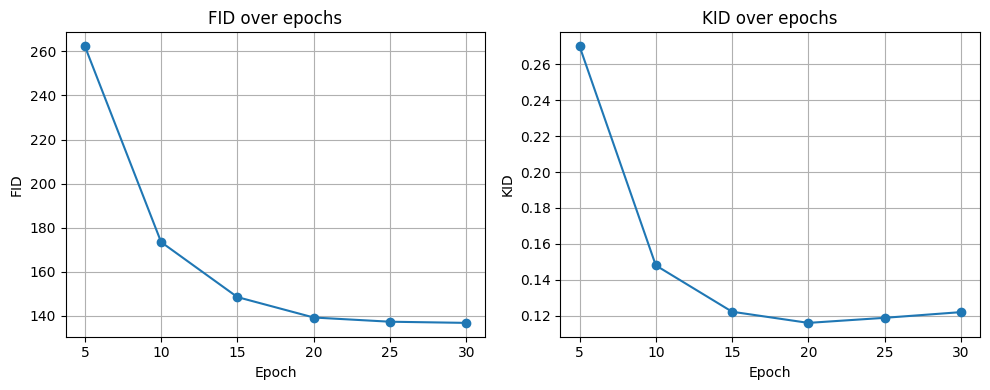

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_list, fid_scores, marker="o")
plt.title("FID over epochs")
plt.xlabel("Epoch")
plt.ylabel("FID")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_list, kid_scores, marker="o")
plt.title("KID over epochs")
plt.xlabel("Epoch")
plt.ylabel("KID")
plt.grid(True)

plt.tight_layout()
plt.show()

wandb.log({
    "FID_KID_curves": wandb.Image(plt.gcf())
})

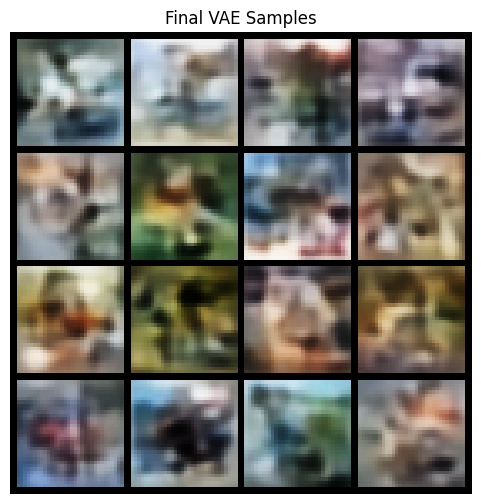

beta,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
latent/mu_mean,▁▃▆▇█▇▇▇▇▇███▇▇▇██████████████
latent/mu_std,█▆▆▅▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
metrics/FID,█▃▂▁▁▁
metrics/KID,█▂▁▁▁▁
time/epoch_sec,█▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂
train/kl_loss,▇█▇▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/kl_weight,▁▂▃▃▄▅▆▆▇█████████████████████
train/recon_loss,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+1,...


In [ ]:
model.eval()
with torch.no_grad():
    z = torch.randn(16, config["latent_dim"]).to(device)
    samples = model.decode(z)
    samples = (samples + 1) / 2
    samples = samples.clamp(0, 1)

grid = vutils.make_grid(samples, nrow=4)
plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.axis("off")
plt.title("Final VAE Samples")
plt.show()

wandb.log({
    "final_samples": wandb.Image(
        grid.permute(1, 2, 0).cpu().numpy(),
        caption="Final VAE Samples"
    )
})

wandb.finish()